### Imports

In [1]:
import pandas as pd
import numpy as np

from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering

from scipy.spatial.distance import cdist
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import normalize
from sklearn import preprocessing
from sklearn.utils import resample

import statsmodels.stats.api as sms
import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot
import scipy.stats as stats
from scipy.stats import pearsonr
import scipy.cluster.hierarchy as shc

import pylab 

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for plot styling

pd.set_option('display.float_format',lambda x: '%.3f' %x)

import warnings
warnings.filterwarnings("ignore")

### Load the dataset

In [2]:
# Load the datasets

this_year = 2018

# Load the datasets for 2018 data
dataYear = pd.read_csv(r'C:\Users\abandyopadhyay\ALOKPARNA\RCV_SLOTTING\Dataset\Slotting_2018.csv', header=0, encoding = 'unicode_escape')
print("----- Feature Set for Current Year ----- \n", list(dataYear.columns))

# # Load the datasets for 2017 data
# dataPriorYear = pd.read_csv(r'C:\Users\abandyopadhyay\ALOKPARNA\RCV_SLOTTING\Dataset\Slotting_2017.csv', header=0, encoding = 'unicode_escape')
# print("\n----- Feature Set for Prior Year ----- \n", list(dataPriorYear.columns))

# Load the datasets for 2019 data
dataFutureYear = pd.read_csv(r'C:\Users\abandyopadhyay\ALOKPARNA\RCV_SLOTTING\Dataset\Slotting_2019.csv', header=0, encoding = 'unicode_escape')
print("\n----- Feature Set for Future Year ----- \n", list(dataFutureYear.columns))

dataYear = dataYear.fillna(0)
# dataPriorYear = dataPriorYear.fillna(0)
dataFutureYear = dataFutureYear.fillna(0)

----- Feature Set for Current Year ----- 
 ['UniqueId', 'Department', 'Category', 'SubCategory', 'Material', 'Style', 'Dimension', 'ProductSize', 'Volume', 'InventorySegment', 'Color', 'UPC', 'Season_SKU_Introduced', 'Year_SKU_Introduced', 'History_Size_Pct', 'Month', 'Season', 'Year', 'Quarter', 'PlannedUnits', 'PDXPlannedUnits', 'Orders', 'Ordered_Units', 'Avg_Daily_Ordered_Units', 'Days_Ordered', 'Order_Volume', 'Avg_Daily_Volume', 'Experiment_Id']

----- Feature Set for Future Year ----- 
 ['UniqueId', 'Department', 'Category', 'SubCategory', 'Material', 'Style', 'Dimension', 'ProductSize', 'Volume', 'InventorySegment', 'Color', 'UPC', 'Season_SKU_Introduced', 'Year_SKU_Introduced', 'History_Size_Pct', 'Month', 'Season', 'Year', 'Quarter', 'PlannedUnits', 'PDXPlannedUnits', 'Orders', 'Ordered_Units', 'Avg_Daily_Ordered_Units', 'Days_Ordered', 'Order_Volume', 'Avg_Daily_Volume', 'Experiment_Id']


### Function Definitions

In [3]:
# Function to identify whether a product is new or not and add that as a feature in the dataset
def add_NewProduct(data):
    data.loc[(data.Year_SKU_Introduced < this_year) | ((data['Year_SKU_Introduced']).isnull()), 'NewProduct'] = '0' # Existing product
    data.loc[data.Year_SKU_Introduced >= this_year, 'NewProduct'] = '1' # New product
    return (data)

In [4]:
# Function to add future year's Contract' as a feature in the current year dataset
def add_FutureContract(data, dataFuture):
    dataFuture.loc[dataFuture.PlannedUnits != 0, 'Contract'] = dataFuture['PlannedUnits']
    dataFuture.loc[dataFuture.PlannedUnits == 0, 'Contract'] = dataFuture['PDXPlannedUnits']    
    data['Future_Contract'] = dataFuture['Contract']
    return (data)

In [5]:
# Function to add 'Contract' as a feature in the dataset
def add_Contract(data):
    data.loc[data.PlannedUnits != 0, 'Contract'] = data['PlannedUnits']
    data.loc[data.PlannedUnits == 0, 'Contract'] = data['PDXPlannedUnits']
    return (data)

In [6]:
# Function to add 'Popularity': a measure of how much was contracted and how much was actually sold
def add_Popularity(data):
    data['Popularity'] = ((data['Ordered_Units']-data['Contract'])/data['Ordered_Units'])*100
    return (data)

In [7]:
# Function to Group products by Experiment Id
def group_by_expId(data):
    groupedData = data.groupby(['Experiment_Id']).agg({'Contract': 'sum', 'Orders': 'sum', 'Ordered_Units': 'sum', 'Days_Ordered': 'sum', 'Order_Volume': 'sum', 'Avg_Daily_Volume': 'mean'})
    # Remove the index and flatten the dataset
    groupedData.reset_index(inplace=True)
    print("Grouped dataset (by Experiment Id) shape: ", groupedData.shape)
    return (groupedData)

In [8]:
# Function to Group products by Experiment Id and Seasons
def group_by_Seasons(data):
    groupedData = data.groupby(['Experiment_Id', 'Season']).agg({'Contract': 'sum', 'Orders': 'sum', 'Ordered_Units': 'sum', 'Days_Ordered': 'sum', 'Order_Volume': 'sum', 'Avg_Daily_Volume': 'mean'})
    # Remove the index and flatten the dataset
    groupedData.reset_index(inplace=True)
    print("Grouped dataset (by Experiment Id and Seasons) shape: ", groupedData.shape)
    return (groupedData)

In [9]:
# Function to Group products by Experiment Id and Categorical Descriptions
def group_by_Categoricals(data):
    groupedData = data.groupby(['Experiment_Id', 'Department', 'Category', 'SubCategory', 'Material', 'Style', 'Dimension', 'ProductSize', 'Volume', 'InventorySegment', 'Color', 'UPC', 'NewProduct']).agg({'Demand': 'sum', 'Orders': 'sum','Ordered_Units': 'sum', 'Avg_Daily_Ordered_Units': 'mean', 'Days_Ordered': 'sum', 'Order_Volume': 'sum', 'Avg_Daily_Volume': 'mean'})
    # Remove index and flatten the dataset
    groupedData.reset_index(inplace=True)
    print("Grouped dataset (Experiment Id and Categoricals) shape: ", groupedData.shape)
    return (groupedData)

In [10]:
# Function to Group products by Experiment Id, Seasons and Categorical Descriptions
def group_by_SeasonsAndCategoricals(data):
    groupedData = data.groupby(['Experiment_Id', 'Season', 'Department', 'Category', 'SubCategory', 'Material', 'Style', 'Dimension', 'ProductSize', 'Volume', 'InventorySegment', 'Color', 'UPC', 'NewProduct']).agg({'Contract': 'sum', 'Future_Contract': 'sum', 'Popularity': 'sum', 'Orders': 'sum','Ordered_Units': 'sum', 'Avg_Daily_Ordered_Units': 'mean', 'Days_Ordered': 'sum', 'Order_Volume': 'sum', 'Avg_Daily_Volume': 'mean'})
    # Remove index and flatten the dataset
    groupedData.reset_index(inplace=True)
    print("\nGrouped dataset (Experiment Id, Seasons and Categoricals) shape: ", groupedData.shape)
    return (groupedData)

In [11]:
# Function to select the Top80 selling products
def get_Top80(data):
    # Calculate % Ordered_Units 
    totalOrdUnits = data['Ordered_Units'].sum()
    data['Pct_OrdUnits'] = (data['Ordered_Units']/totalOrdUnits)*100

    # Sort the dataset based on % Ordered_Units 
    data = data.sort_values('Pct_OrdUnits',ascending=False)
    data['Cumsum_Pct_OrdUnits'] = data['Pct_OrdUnits'].cumsum()

    # Find the orders with Top 80 sales (ordered units)
    dataTop80 = data[data.Cumsum_Pct_OrdUnits <= 80]

    # Drop the Pct_OrdUnits and Cumsum_Pct_OrdUnits columns
    dataTop80 = dataTop80.drop(['Pct_OrdUnits', 'Cumsum_Pct_OrdUnits'], axis=1)

    print("Dataset shape after retaining the Top80 selling products: ", dataTop80.shape)
    return (dataTop80)

In [12]:
# Function for K-Means clustering
def KMeans_clusterLabels(data, n):# Cluster data using k-means and get the cluster labels
    model = KMeans(n_clusters=n, random_state=1)
    model.fit(data)
    model_p = model.predict(data)
    # Get cluster labels
    cluster_label = model.labels_
    #Plot the clusters
    plt.scatter(data.iloc[:, 0], data.iloc[:, 1], c=cluster_label, s=50, cmap='viridis')
    centers = model.cluster_centers_
    plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)
    
    # Recoding the Cluster '0' as Cluster 'n'
    for i in range(len(cluster_label)): 
        if cluster_label[i] == 0:
            cluster_label[i] = n
    
    return (cluster_label)

In [13]:
# Function for Agglomerative clustering
def Agglomerative_clusterLabels(data_scaled, n):# Cluster data using k-means and get the cluster labels
    model = AgglomerativeClustering(n_clusters=n, affinity='euclidean', linkage='ward')
    model.fit_predict(data_scaled)
    # Get cluster labels
    cluster_label = model.labels_
    #Plot the clusters
    plt.scatter(data.iloc[:, 0], data.iloc[:, 1], c=cluster_label, s=50, cmap='viridis')

    # Recoding the Cluster '0' as Cluster 'n'
    for i in range(len(cluster_label)): 
        if cluster_label[i] == 0:
            cluster_label[i] = n
    
    return (cluster_label)

In [14]:
# Function for adding binary values for ClusterLabels
def add_binary_response_Kmeans_clusterLabels(data):
    data.loc[data.KMeans_Cluster3_Label == 1, 'Cluster_1'] = '1'
    data.loc[data.KMeans_Cluster3_Label != 1, 'Cluster_1'] = '0'
    
    data.loc[data.KMeans_Cluster3_Label == 2, 'Cluster_2'] = '1'
    data.loc[data.KMeans_Cluster3_Label != 2, 'Cluster_2'] = '0'
    
    data.loc[data.KMeans_Cluster3_Label == 3, 'Cluster_3'] = '1'
    data.loc[data.KMeans_Cluster3_Label != 3, 'Cluster_3'] = '0'
    
    return (data)

In [15]:
# Function for creating Classification Dataset
def create_Classification_Dataset(data):
    # Add the new feature 'Suggested_Storage_Type' and the target 'Class' based on the 'Avg_Daily_Volume'
    data.loc[data.Avg_Daily_Volume <= 4216.22, 'Suggested_Storage_Type'] = 'Flat Rack'
    data.loc[data.Avg_Daily_Volume <= 4216.22, 'Class'] = '1'
    data.loc[(data.Avg_Daily_Volume > 4216.22) & (data.Avg_Daily_Volume <= 21081.6), 'Suggested_Storage_Type'] = 'Flow Rack' 
    data.loc[(data.Avg_Daily_Volume > 4216.22) & (data.Avg_Daily_Volume <= 21081.6), 'Class'] = '2' 
    data.loc[data.Avg_Daily_Volume > 21081.6, 'Suggested_Storage_Type'] = 'Big Pack'
    data.loc[data.Avg_Daily_Volume > 21081.6, 'Class'] = '3'

    return (data)

In [16]:
# Function to calculate Pearson Co-edfficient and p-values of a matrix
def corrcoef_loop(matrix):
    rows, cols = matrix.shape[0], matrix.shape[1]
    r = np.ones(shape=(rows, rows))
    p = np.ones(shape=(rows, rows))
    for i in range(rows):
        for j in range(i+1, rows):
            r_, p_ = pearsonr(matrix[i], matrix[j])
            r[i, j] = r[j, i] = r_
            p[i, j] = p[j, i] = p_
    return r, p

In [17]:
# Function for Histogram plot
def plot_Histograms(data):
    fig, ax = plt.subplots(1, 2, figsize=(20,4))
    volume = data['Volume'].values
    sns.distplot(volume, ax=ax[0], color='r')
    ax[0].set_title('Distribution of Volume', fontsize=14)
    ax[0].set_xlim([min(volume), max(volume)])

    orders = data['Orders'].values
    sns.distplot(orders, ax=ax[1], color='b')
    ax[1].set_title('Distribution of Orders', fontsize=14)
    ax[1].set_xlim([min(orders), max(orders)])
    
    fig, ax = plt.subplots(1, 2, figsize=(20,4))
    ordered_Units = data['Ordered_Units'].values
    sns.distplot(ordered_Units, ax=ax[0], color='g')
    ax[0].set_title('Distribution of Ordered_Units', fontsize=14)
    ax[0].set_xlim([min(ordered_Units), max(ordered_Units)])
    
    avg_Daily_Ordered_Units = data['Avg_Daily_Ordered_Units'].values
    sns.distplot(avg_Daily_Ordered_Units, ax=ax[1], color='m')
    ax[1].set_title('Distribution of Avg_Daily_Ordered_Units', fontsize=14)
    ax[1].set_xlim([min(avg_Daily_Ordered_Units), max(avg_Daily_Ordered_Units)])
    
    fig, ax = plt.subplots(1, 2, figsize=(20,4))
    days_Ordered = data['Days_Ordered'].values
    sns.distplot(days_Ordered, ax=ax[0], color='r')
    ax[0].set_title('Distribution of Days_Ordered', fontsize=14)
    ax[0].set_xlim([min(days_Ordered), max(days_Ordered)])
    
    order_Volume = data['Order_Volume'].values
    sns.distplot(order_Volume, ax=ax[1], color='b')
    ax[1].set_title('Distribution of Order_Volume', fontsize=14)
    ax[1].set_xlim([min(order_Volume), max(order_Volume)])    
    
    fig, ax = plt.subplots(1, 2, figsize=(20,4))
    avg_Daily_Volume = data['Avg_Daily_Volume'].values
    sns.distplot(avg_Daily_Volume, ax=ax[0], color='g')
    ax[0].set_title('Distribution of Avg_Daily_Volume', fontsize=14)
    ax[0].set_xlim([min(avg_Daily_Volume), max(avg_Daily_Volume)])

In [18]:
# Function for KSTest and QQplot
def ksTest_QQPlots(data):
    print("Volume: ", stats.kstest(data['Volume'], 'norm'))
    qqplot(data['Volume'], line='s')
    plt.show()
    print("Orders: ", stats.kstest(data['Orders'], 'norm'))
    qqplot(data['Orders'], line='s')
    plt.show()
    print("Ordered_Units: ", stats.kstest(data['Ordered_Units'], 'norm'))
    qqplot(data['Ordered_Units'], line='s')
    plt.show()
    print("Avg_Daily_Ordered_Units: ", stats.kstest(data['Avg_Daily_Ordered_Units'], 'norm'))
    qqplot(data['Avg_Daily_Ordered_Units'], line='s')
    plt.show()
    print("Days_Ordered: ", stats.kstest(data['Days_Ordered'], 'norm'))
    qqplot(data['Days_Ordered'], line='s')
    plt.show()
    print("Order_Volume: ", stats.kstest(data['Order_Volume'], 'norm'))
    qqplot(data['Order_Volume'], line='s')
    plt.show()
    print("Avg_Daily_Volume: ", stats.kstest(data['Avg_Daily_Volume'], 'norm'))
    qqplot(data['Avg_Daily_Volume'], line='s')
    plt.show()

### Dataset ETL and Selection of Top80 Sales

In [19]:
# Add a new feature 'currentContract'
dataYear = add_Contract(dataYear)

# Add a new feature 'futureContract'
dataYear = add_FutureContract(dataYear, dataFutureYear)

# Remove those Data for which there are no Orders
dfOrders = dataYear[dataYear.Orders != 0]

# Add a new feature 'NewProduct' to identify whether a product is New or Existing
dfOrders = add_NewProduct(dfOrders)
print("0: Existing Product; 1: New Product")
print(dfOrders['NewProduct'].value_counts())

# Add a new feature 'popularity' to measure how much was contracted and how much was actually sold
dfOrders = add_Popularity(dfOrders)

# Group yearly dataset by Experiment_Id, Seasons and Categoricals
groupedSeasons = group_by_SeasonsAndCategoricals(dfOrders)

groupedSpring = groupedSeasons.loc[groupedSeasons['Season'] == 0].drop(['Season'], axis=1)
groupedFall = groupedSeasons.loc[groupedSeasons['Season'] == 1].drop(['Season'], axis=1)
print("Spring with categorical dataset shape: ", groupedSpring.shape)
print("Fall with categorical dataset shape: ", groupedFall.shape)

dfSpring_Top80 = get_Top80(groupedSpring)
dfFall_Top80 = get_Top80(groupedFall)

print("\n----- Feature Set : dfSpring_Top80 ----- \n", list(dfSpring_Top80.columns))
print("\n----- Feature Set : dfFall_Top80 ----- \n", list(dfFall_Top80.columns))

0: Existing Product; 1: New Product
0    131966
1     25081
Name: NewProduct, dtype: int64

Grouped dataset (Experiment Id, Seasons and Categoricals) shape:  (33005, 23)
Spring with categorical dataset shape:  (15050, 22)
Fall with categorical dataset shape:  (17955, 22)
Dataset shape after retaining the Top80 selling products:  (2280, 22)
Dataset shape after retaining the Top80 selling products:  (2548, 22)

----- Feature Set : dfSpring_Top80 ----- 
 ['Experiment_Id', 'Department', 'Category', 'SubCategory', 'Material', 'Style', 'Dimension', 'ProductSize', 'Volume', 'InventorySegment', 'Color', 'UPC', 'NewProduct', 'Contract', 'Future_Contract', 'Popularity', 'Orders', 'Ordered_Units', 'Avg_Daily_Ordered_Units', 'Days_Ordered', 'Order_Volume', 'Avg_Daily_Volume']

----- Feature Set : dfFall_Top80 ----- 
 ['Experiment_Id', 'Department', 'Category', 'SubCategory', 'Material', 'Style', 'Dimension', 'ProductSize', 'Volume', 'InventorySegment', 'Color', 'UPC', 'NewProduct', 'Contract', 'Fu

In [20]:
dfSpring_Top80

,Experiment_Id,Department,Category,SubCategory,Material,Style,Dimension,ProductSize,Volume,InventorySegment,...,NewProduct,Contract,Future_Contract,Popularity,Orders,Ordered_Units,Avg_Daily_Ordered_Units,Days_Ordered,Order_Volume,Avg_Daily_Volume
3258,6236,Men's,Accessories,Headwear,A18-BLK,M Acrylic Watch Hat,,OFA,61.640,A,...,0,113485.000,187848.000,23.853,10876.000,123524.000,771.000,164.000,7614016.000,47546.667
2726,5581,Men's,Accessories,Headwear,100289-211,M Odessa Cap,,OFA,96.000,A,...,0,52985.000,108944.000,96.171,22204.000,65879.000,409.833,164.000,6324384.000,39393.833
15864,23691,Men's,First Layer Tops,Knits,K87-BLK,M Workwear Pocket SS T Shirt,REG,LRG,97.660,A,...,0,50067.000,69855.000,67.825,18765.000,58728.000,365.500,164.000,5735374.000,35734.333
3266,6240,Men's,Accessories,Headwear,A18-CLH,M Acrylic Watch Hat,,OFA,44.110,A,...,0,55345.000,70819.000,-77.386,7409.000,51174.000,318.000,163.000,2257281.000,14051.667
15866,23692,Men's,First Layer Tops,Knits,K87-BLK,M Workwear Pocket SS T Shirt,REG,MED,96.170,A,...,0,42451.000,59228.000,67.445,14188.000,50972.000,311.500,164.000,4901974.000,30020.500
15870,23694,Men's,First Layer Tops,Knits,K87-BLK,M Workwear Pocket SS T Shirt,REG,XLG,105.840,A,...,0,44490.000,62072.000,52.058,19694.000,49894.000,314.333,164.000,5280777.000,33315.667
16031,23886,Men's,First Layer Tops,Knits,K87-NVY,M Workwear Pocket SS T Shirt,REG,LRG,113.500,A,...,0,45329.000,58606.000,15.386,19134.000,46168.000,288.333,164.000,5240068.000,32801.167
16037,23889,Men's,First Layer Tops,Knits,K87-NVY,M Workwear Pocket SS T Shirt,REG,XLG,128.430,A,...,0,44535.000,57582.000,10.723,19995.000,45102.000,282.167,164.000,5792447.000,36299.500
15987,23834,Men's,First Layer Tops,Knits,K87-HGY,M Workwear Pocket SS T Shirt,REG,LRG,100.270,A,...,0,42376.000,57263.000,37.786,21430.000,45101.000,281.333,164.000,4522274.000,28271.500
2724,5580,Men's,Accessories,Headwear,100289-001,M Odessa Cap,,OFA,96.000,A,...,0,35509.000,74841.000,56.325,8183.000,43091.000,261.833,164.000,4136736.000,25180.333


In [21]:
dfFall_Top80

,Experiment_Id,Department,Category,SubCategory,Material,Style,Dimension,ProductSize,Volume,InventorySegment,...,NewProduct,Contract,Future_Contract,Popularity,Orders,Ordered_Units,Avg_Daily_Ordered_Units,Days_Ordered,Order_Volume,Avg_Daily_Volume
3259,6236,Men's,Accessories,Headwear,A18-BLK,M Acrylic Watch Hat,,OFA,61.640,A,...,0,560967.000,787324.000,117.042,38155.000,756043.000,4202.167,180.000,46602488.000,259045.000
3267,6240,Men's,Accessories,Headwear,A18-CLH,M Acrylic Watch Hat,,OFA,44.110,A,...,0,330940.000,436001.000,12.053,28854.000,375921.000,2088.333,180.000,16581872.000,92137.667
3245,6226,Men's,Accessories,Headwear,A18-019,M Acrylic Watch Hat,,OFA,41.150,A,...,0,283116.000,372239.000,5.840,22336.000,290703.000,1620.167,179.000,11962425.000,66683.667
3265,6239,Men's,Accessories,Headwear,A18-BRN,M Acrylic Watch Hat,,OFA,46.870,A,...,0,238883.000,337811.000,14.822,18108.000,257305.000,1427.000,180.000,12059882.000,66905.333
3275,6247,Men's,Accessories,Headwear,A18-NVY,M Acrylic Watch Hat,,OFA,45.170,A,...,0,154798.000,217011.000,116.327,11454.000,199654.000,1109.833,180.000,9018368.000,50149.667
3247,6227,Men's,Accessories,Headwear,A18-247,M Acrylic Watch Hat,,OFA,47.030,A,...,0,168876.000,209225.000,-115.067,15200.000,155954.000,903.000,171.000,7334513.000,42488.333
3263,6238,Men's,Accessories,Headwear,A18-BOG,M Acrylic Watch Hat,,OFA,57.230,A,...,0,132084.000,192775.000,-58.211,13487.000,145171.000,811.333,178.000,8308134.000,46445.500
3273,6245,Men's,Accessories,Headwear,A18-HGY,M Acrylic Watch Hat,,OFA,41.760,A,...,0,96157.000,115960.000,117.233,7912.000,139181.000,795.333,176.000,5812195.000,33239.333
3287,6258,Men's,Accessories,Headwear,A202-BLK,M Fleece 2 in 1 Headwear,,OFA,96.000,A,...,0,113442.000,145855.000,-65.475,15500.000,121415.000,675.833,176.000,11655840.000,64931.667
3297,6264,Men's,Accessories,Headwear,A205-BLK,M Acrylic Knit Hat,,OFA,30.940,A,...,0,116663.000,136211.000,-84.598,9596.000,115862.000,641.333,179.000,3584767.000,19862.667


### Data Transformation and Visualization

In [22]:
# dataSpring = dfSpring_Top80[['Volume', 'Orders', 'Ordered_Units', 'Avg_Daily_Ordered_Units', 'Days_Ordered', 'Order_Volume', 'Avg_Daily_Volume']]

# # Data Normalization
# data_normed_Spring = normalize(dataSpring)
# data_normed_Spring = pd.DataFrame(data_normed_Spring, columns=dataSpring.columns)

# # Data Standard Scaler
# # Create scaler
# scaler = preprocessing.StandardScaler()
# # Transform the feature
# data_scaled_Spring = scaler.fit_transform(dataSpring)
# data_scaled_Spring = pd.DataFrame(data_scaled_Spring, columns=dataSpring.columns)

# Plot Histograms for Raw Data, Normalized Data and Standard-Scaled Data
# plot_Histograms(dataSpring)
# plot_Histograms(data_normed_Spring)
# plot_Histograms(data_scaled_Spring)

# KSTest and QQPlots for Raw Data, Normalized Data and Standard-Scaled Data
# ksTest_QQPlots(dataSpring)
# ksTest_QQPlots(data_normed_Spring)
# ksTest_QQPlots(data_scaled_Spring)

In [23]:
# dataFall = dfFall_Top80[['Volume', 'Orders', 'Ordered_Units', 'Avg_Daily_Ordered_Units', 'Days_Ordered', 'Order_Volume', 'Avg_Daily_Volume']]

# # Data normalization
# data_normed_Fall = normalize(dataFall)
# data_normed_Fall = pd.DataFrame(data_normed_Fall, columns=dataFall.columns)

# # Data Standard Scaler
# # Create scaler
# scaler = preprocessing.StandardScaler()
# # Transform the feature
# data_scaled_Fall = scaler.fit_transform(dataFall)
# data_scaled_Fall = pd.DataFrame(data_scaled_Fall, columns=dataFall.columns)

# Plot Histograms for Raw Data, Normalized Data and Standard-Scaled Data
# plot_Histograms(dataFall)
# plot_Histograms(data_normed_Fall)
# plot_Histograms(data_scaled_Fall)

# KSTest and QQPlots for Raw Data, Normalized Data and Standard-Scaled Data
# ksTest_QQPlots(dataFall)
# ksTest_QQPlots(data_normed_Fall)
# ksTest_QQPlots(data_scaled_Fall)

### Feature Selection for Clustering

In [24]:
CLUSTERING_FEATURE_SET_1 = ['Volume', 'Orders', 'Ordered_Units', 'Days_Ordered', 'Order_Volume']
CLUSTERING_FEATURE_SET_2 = ['Volume', 'Orders', 'Avg_Daily_Ordered_Units', 'Days_Ordered', 'Order_Volume']
CLUSTERING_FEATURE_SET_3 = ['Volume', 'Orders', 'Ordered_Units', 'Days_Ordered', 'Avg_Daily_Volume']
CLUSTERING_FEATURE_SET_4 = ['Volume', 'Orders', 'Avg_Daily_Ordered_Units', 'Days_Ordered', 'Avg_Daily_Volume']
CLUSTERING_FEATURE_SET_5 = ['Future_Contract', 'Popularity', 'Avg_Daily_Ordered_Units']

CLUSTERING_FEATURE_SET = CLUSTERING_FEATURE_SET_4

dfSpring_clust = dfSpring_Top80[CLUSTERING_FEATURE_SET]
dfFall_clust = dfFall_Top80[CLUSTERING_FEATURE_SET]

In [25]:
# Bootstrap Resampling
# from sklearn.utils import resample
# # prepare bootstrap sample
# bootSpring = resample(dfSpring_clust, replace=True)
# bootFall = resample(dfFall_clust, replace=True)

### Calculate Corelation of Selected Features

In [26]:
# corr_Spring = dfSpring_clust.corr()
# corr_Spring.style.background_gradient(cmap='coolwarm', axis=None)

In [27]:
# corr_Fall = dfFall_clust.corr()
# corr_Fall.style.background_gradient(cmap='coolwarm', axis=None)

### Calculate 'p-value' of Corelation matrix

In [28]:
# # Find p-values (p) of Spring Corelation Matrix
# r, p = corrcoef_loop(corr_Spring.values)

# # Convert the p-value matrix into a dataframe for plotting
# p_df = pd.DataFrame(p)
# p_df.columns = CLUSTERING_FEATURE_SET
# p_df.index = CLUSTERING_FEATURE_SET

# p_df.style.background_gradient(cmap='coolwarm', axis=None)

In [29]:
# # Find p-values (p) of Fall Corelation Matrix
# r, p = corrcoef_loop(corr_Fall.values)

# # Convert the p-value matrix into a dataframe for plotting
# p_df = pd.DataFrame(p)
# p_df.columns = CLUSTERING_FEATURE_SET
# p_df.index = CLUSTERING_FEATURE_SET

# p_df.style.background_gradient(cmap='coolwarm', axis=None)

### Calculate 'Confidence Interval' of clustering dataset

In [30]:
# # Calculate confidence interval of Spring dataset
# confInt_Spring =  pd.DataFrame(sms.DescrStatsW(dfSpring_clust).tconfint_mean(),
#                                columns=CLUSTERING_FEATURE_SET)
# print('\n----- Confidence interval of Spring dataset -----\n\n', confInt_Spring)

# # Calculate confidence interval of Fall dataset
# confInt_Fall = pd.DataFrame(sms.DescrStatsW(dfFall_clust).tconfint_mean(),
#                             columns=CLUSTERING_FEATURE_SET)
# print('\n----- Confidence interval of Fall dataset -----\n\n', confInt_Fall)

### Agglomerative Clustering

In [31]:
# data = dfSpring_clust.copy()
# data_scaled = normalize(data)
# data_scaled = pd.DataFrame(data_scaled, columns=data.columns)

# plt.figure(figsize=(10, 7))  
# plt.title("Dendrograms")  
# dend = shc.dendrogram(shc.linkage(data_scaled, method='ward'))

In [32]:
# # Cluster Spring data by Agglomerative Clustering
# # Agglomerative with n=3
# cluster_label = Agglomerative_clusterLabels(data_scaled, 3)

# dfSpring_Top80['Agglo_Cluster3_Label'] = cluster_label
# print("\n----- Spring Cluster_Label counts with Agglomerative n=3 -----")
# print(dfSpring_Top80['Agglo_Cluster3_Label'].value_counts())

# # Clustering Accuracy : Calculate Silhouette Coefficient
# # Evaluate the cluster model for Spring data
# accuracySpring = silhouette_score(data_scaled, cluster_label)
# print("Accuracy of Agglomerative with n=3 on Spring data: ", accuracySpring)

In [33]:
# data = dfFall_clust.copy()
# data_scaled = normalize(data)
# data_scaled = pd.DataFrame(data_scaled, columns=data.columns)

# plt.figure(figsize=(10, 7))  
# plt.title("Dendrograms")  
# dend = shc.dendrogram(shc.linkage(data_scaled, method='ward'))

In [34]:
# # Cluster Fall data by Agglomerative Clustering
# # Agglomerative with n=3
# cluster_label = Agglomerative_clusterLabels(data_scaled, 3)

# dfFall_Top80['Agglo_Cluster3_Label'] = cluster_label
# print("\n----- Fall Cluster_Label counts with Agglomerative n=3 -----")
# print(dfFall_Top80['Agglo_Cluster3_Label'].value_counts())

# # Clustering Accuracy : Calculate Silhouette Coefficient
# # Evaluate the cluster model for Fall data
# accuracyFall = silhouette_score(data_scaled, cluster_label)
# print("Accuracy of Agglomerative with n=3 on Fall data: ", accuracyFall)

### K-Means Clustering


----- Spring Cluster_Label counts with KMeans n=3 -----
3    2193
2      80
1       7
Name: KMeans_Cluster3_Label, dtype: int64
Accuracy of KMeans with n=3 on Spring data:  0.8342666372524808


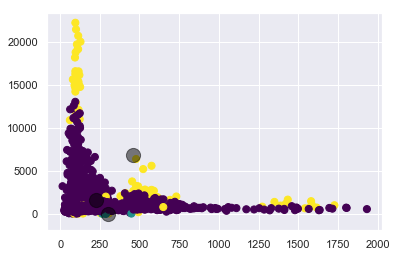

In [35]:
# Cluster Spring by K-Means Clustering
# Kmeans with n=3 on Spring Data
spring_cluster3_label = KMeans_clusterLabels(dfSpring_clust, 3)
dfSpring_Top80['KMeans_Cluster3_Label'] = spring_cluster3_label

print("\n----- Spring Cluster_Label counts with KMeans n=3 -----")
print(dfSpring_Top80['KMeans_Cluster3_Label'].value_counts())

# Clustering Accuracy : Calculate Silhouette Coefficient
# Evaluate the 3-cluster model for Spring
accuracySpring = silhouette_score(dfSpring_clust, spring_cluster3_label)
print("Accuracy of KMeans with n=3 on Spring data: ", accuracySpring)

# Add binary response values for each Cluster Labels
dfSpring_Top80 = add_binary_response_Kmeans_clusterLabels(dfSpring_Top80)


----- Fall Cluster_Label counts with KMeans n=3 -----
3    2483
2      51
1      14
Name: KMeans_Cluster3_Label, dtype: int64
Accuracy of KMeans with n=3 on Fall data:  0.9080083963489669


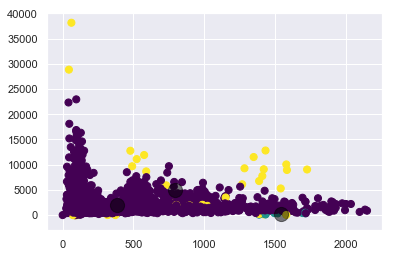

In [36]:
# Cluster Fall by K-Means Clustering
# Kmeans with n=3 on Fall Data
fall_cluster3_label = KMeans_clusterLabels(dfFall_clust, 3)
dfFall_Top80['KMeans_Cluster3_Label'] = fall_cluster3_label

print("\n----- Fall Cluster_Label counts with KMeans n=3 -----")
print(dfFall_Top80['KMeans_Cluster3_Label'].value_counts())

# Clustering Accuracy : Calculate Silhouette Coefficient
# Evaluate the 3-cluster model for Fall
accuracyFall = silhouette_score(dfFall_clust, fall_cluster3_label)
print("Accuracy of KMeans with n=3 on Fall data: ", accuracyFall)

# Add binary response values for each Cluster Labels
dfFall_Top80 = add_binary_response_Kmeans_clusterLabels(dfFall_Top80)

In [37]:
# Create datasets for Classification (Spring and Fall)
dfSpring = create_Classification_Dataset(dfSpring_Top80)
print("Spring dataset shape: ", dfSpring.shape)
print("----- Feature Set ----- \n", list(dfSpring.columns))
print("\n")
dfFall = create_Classification_Dataset(dfFall_Top80)
print("Fall dataset shape: ", dfFall.shape)
print("----- Feature Set ----- \n", list(dfFall.columns))

Spring dataset shape:  (2280, 28)
----- Feature Set ----- 
 ['Experiment_Id', 'Department', 'Category', 'SubCategory', 'Material', 'Style', 'Dimension', 'ProductSize', 'Volume', 'InventorySegment', 'Color', 'UPC', 'NewProduct', 'Contract', 'Future_Contract', 'Popularity', 'Orders', 'Ordered_Units', 'Avg_Daily_Ordered_Units', 'Days_Ordered', 'Order_Volume', 'Avg_Daily_Volume', 'KMeans_Cluster3_Label', 'Cluster_1', 'Cluster_2', 'Cluster_3', 'Suggested_Storage_Type', 'Class']


Fall dataset shape:  (2548, 28)
----- Feature Set ----- 
 ['Experiment_Id', 'Department', 'Category', 'SubCategory', 'Material', 'Style', 'Dimension', 'ProductSize', 'Volume', 'InventorySegment', 'Color', 'UPC', 'NewProduct', 'Contract', 'Future_Contract', 'Popularity', 'Orders', 'Ordered_Units', 'Avg_Daily_Ordered_Units', 'Days_Ordered', 'Order_Volume', 'Avg_Daily_Volume', 'KMeans_Cluster3_Label', 'Cluster_1', 'Cluster_2', 'Cluster_3', 'Suggested_Storage_Type', 'Class']


In [38]:
## Box-plots
# sns.boxplot(x='Suggested_Storage_Type', y='Avg_Daily_Volume', data=dfSpring, showfliers=False)
# sns.boxplot(x='Agglo_Cluster3_Label', y='Avg_Daily_Volume', data=dfSpring, showfliers=False)
# sns.boxplot(x='KMeans_Cluster3_Label', y='Avg_Daily_Volume', data=dfSpring, showfliers=False)
# sns.boxplot(x='Suggested_Storage_Type', y='Avg_Daily_Volume', data=dfFall, showfliers=False)
# sns.boxplot(x='Agglo_Cluster3_Label', y='Avg_Daily_Volume', data=dfFall, showfliers=False)
# sns.boxplot(x='KMeans_Cluster3_Label', y='Avg_Daily_Volume', data=dfFall, showfliers=False)

### Classification - Multinomial Logistic Regression

#### Resampling data to have equal cluster labels

In [39]:
# Resampling SPRING Data

print(dfSpring['KMeans_Cluster3_Label'].value_counts())

# sampling size: mean of cluster label assignments
n_samples = np.mean(dfSpring['KMeans_Cluster3_Label'].value_counts())

# Separate majority and minority classes
dfSpring_clus1 = dfSpring[dfSpring['KMeans_Cluster3_Label']==1]
dfSpring_clus2 = dfSpring[dfSpring['KMeans_Cluster3_Label']==2]
dfSpring_clus3 = dfSpring[dfSpring['KMeans_Cluster3_Label']==3]

# Resample Cluster1 assignments
dfSpring_clus1_resampled = resample(dfSpring_clus1, 
                                     replace=True,             # sample with replacement
                                     n_samples=int(n_samples), # to match the mean of three cluster assignments
                                     random_state=123)         # reproducible results

# Resample Cluster2 assignments
dfSpring_clus2_resampled = resample(dfSpring_clus2, 
                                     replace=True,             # sample with replacement
                                     n_samples=int(n_samples), # to match the mean of three cluster assignments
                                     random_state=123)         # reproducible results

# Resample Cluster3 assignments
dfSpring_clus3_resampled = resample(dfSpring_clus3, 
                                     replace=False,            # sample without replacement
                                     n_samples=int(n_samples), # to match the mean of three cluster assignments
                                     random_state=123)         # reproducible results

# Combine the resampled classes
dfSpring_resampled = pd.concat([dfSpring_clus1_resampled, dfSpring_clus2_resampled, dfSpring_clus3_resampled])

print("\nResampled Spring dataset shape: ", dfSpring_resampled.shape)
print(dfSpring_resampled['KMeans_Cluster3_Label'].value_counts())

3    2193
2      80
1       7
Name: KMeans_Cluster3_Label, dtype: int64

Resampled Spring dataset shape:  (2280, 28)
3    760
1    760
2    760
Name: KMeans_Cluster3_Label, dtype: int64


In [40]:
print(dfSpring['Cluster_1'].value_counts())
print(dfSpring_resampled['Cluster_1'].value_counts())
print(dfSpring['Cluster_2'].value_counts())
print(dfSpring_resampled['Cluster_2'].value_counts())
print(dfSpring['Cluster_3'].value_counts())
print(dfSpring_resampled['Cluster_3'].value_counts())

0    2273
1       7
Name: Cluster_1, dtype: int64
0    1520
1     760
Name: Cluster_1, dtype: int64
0    2200
1      80
Name: Cluster_2, dtype: int64
0    1520
1     760
Name: Cluster_2, dtype: int64
1    2193
0      87
Name: Cluster_3, dtype: int64
0    1520
1     760
Name: Cluster_3, dtype: int64


In [41]:
# Resampling FALL Data

print(dfFall['KMeans_Cluster3_Label'].value_counts())

# sampling size: mean of cluster label assignments
n_samples = np.mean(dfFall['KMeans_Cluster3_Label'].value_counts())

# Separate majority and minority classes
dfFall_clus1 = dfFall[dfFall['KMeans_Cluster3_Label']==1]
dfFall_clus2 = dfFall[dfFall['KMeans_Cluster3_Label']==2]
dfFall_clus3 = dfFall[dfFall['KMeans_Cluster3_Label']==3]

# Resample Cluster1 assignments
dfFall_clus1_resampled = resample(dfFall_clus1, 
                                     replace=True,             # sample with replacement
                                     n_samples=int(n_samples), # to match the mean of three cluster assignments
                                     random_state=123)         # reproducible results

# Resample Cluster2 assignments
dfFall_clus2_resampled = resample(dfFall_clus2, 
                                     replace=True,             # sample with replacement
                                     n_samples=int(n_samples), # to match the mean of three cluster assignments
                                     random_state=123)         # reproducible results

# Resample Cluster3 assignments
dfFall_clus3_resampled = resample(dfFall_clus3, 
                                     replace=False,            # sample without replacement
                                     n_samples=int(n_samples), # to match the mean of three cluster assignments
                                     random_state=123)         # reproducible results

# Combine the resampled classes
dfFall_resampled = pd.concat([dfFall_clus1_resampled, dfFall_clus2_resampled, dfFall_clus3_resampled])

print("\nResampled Spring dataset shape: ", dfFall_resampled.shape)
print(dfFall_resampled['KMeans_Cluster3_Label'].value_counts())

3    2483
2      51
1      14
Name: KMeans_Cluster3_Label, dtype: int64

Resampled Spring dataset shape:  (2547, 28)
3    849
1    849
2    849
Name: KMeans_Cluster3_Label, dtype: int64


In [42]:
print(dfFall['Cluster_1'].value_counts())
print(dfFall_resampled['Cluster_1'].value_counts())
print(dfFall['Cluster_2'].value_counts())
print(dfFall_resampled['Cluster_2'].value_counts())
print(dfFall['Cluster_3'].value_counts())
print(dfFall_resampled['Cluster_3'].value_counts())

0    2534
1      14
Name: Cluster_1, dtype: int64
0    1698
1     849
Name: Cluster_1, dtype: int64
0    2497
1      51
Name: Cluster_2, dtype: int64
0    1698
1     849
Name: Cluster_2, dtype: int64
1    2483
0      65
Name: Cluster_3, dtype: int64
0    1698
1     849
Name: Cluster_3, dtype: int64


In [43]:
#Corelation matrix of Features: Spring Data
FEATURES =['Volume', 'NewProduct', 'Contract', 'Future_Contract', 'Popularity', 'Orders', 'Ordered_Units', 'Avg_Daily_Ordered_Units', 'Days_Ordered', 'Order_Volume', 'Avg_Daily_Volume']
corr_Spring = dfSpring_resampled[FEATURES].corr()
corr_Spring.style.background_gradient(cmap='coolwarm', axis=None)

,Volume,Contract,Future_Contract,Popularity,Orders,Ordered_Units,Avg_Daily_Ordered_Units,Days_Ordered,Order_Volume,Avg_Daily_Volume
Volume,1,-0.22128,-0.202037,0.0380557,-0.25357,-0.230577,-0.15441,0.0346294,0.357885,-0.050145
Contract,-0.22128,1,0.971639,0.0277261,0.868473,0.992464,-0.179431,0.444679,0.67189,-0.313089
Future_Contract,-0.202037,0.971639,1,0.0332496,0.799656,0.979042,-0.159244,0.423999,0.678496,-0.289187
Popularity,0.0380557,0.0277261,0.0332496,1,0.0355221,0.0330113,0.0611393,0.0638587,0.0498606,0.0704691
Orders,-0.25357,0.868473,0.799656,0.0355221,1,0.846023,-0.248766,0.496994,0.626591,-0.358565
Ordered_Units,-0.230577,0.992464,0.979042,0.0330113,0.846023,1,-0.137102,0.406745,0.668008,-0.272511
Avg_Daily_Ordered_Units,-0.15441,-0.179431,-0.159244,0.0611393,-0.248766,-0.137102,1,-0.83404,-0.327566,0.969554
Days_Ordered,0.0346294,0.444679,0.423999,0.0638587,0.496994,0.406745,-0.83404,1,0.516493,-0.869865
Order_Volume,0.357885,0.67189,0.678496,0.0498606,0.626591,0.668008,-0.327566,0.516493,1,-0.366738
Avg_Daily_Volume,-0.050145,-0.313089,-0.289187,0.0704691,-0.358565,-0.272511,0.969554,-0.869865,-0.366738,1


In [44]:
# Find p-values (p) of Spring Corelation Matrix
r, p = corrcoef_loop(corr_Spring.values)
p_df = pd.DataFrame(p, columns=corr_Spring.columns, index=corr_Spring.index)
p_df.style.background_gradient(cmap='coolwarm', axis=None)

,Volume,Contract,Future_Contract,Popularity,Orders,Ordered_Units,Avg_Daily_Ordered_Units,Days_Ordered,Order_Volume,Avg_Daily_Volume
Volume,1,0.156984,0.163231,0.981928,0.167967,0.138465,0.641776,0.970136,0.887553,0.882718
Contract,0.156984,1,7.43085e-12,0.417406,1.90714e-07,2.15343e-12,0.0587771,0.0145111,0.00264178,0.0220272
Future_Contract,0.163231,7.43085e-12,1,0.413553,1.07817e-06,4.0593e-12,0.063722,0.0163964,0.00259268,0.0245128
Popularity,0.981928,0.417406,0.413553,1,0.468457,0.411664,0.869004,0.8162,0.415817,0.796339
Orders,0.167967,1.90714e-07,1.07817e-06,0.468457,1,6.86775e-07,0.0348853,0.00697075,0.00225208,0.0116802
Ordered_Units,0.138465,2.15343e-12,4.0593e-12,0.411664,6.86775e-07,1,0.0766008,0.0206154,0.00366552,0.0305384
Avg_Daily_Ordered_Units,0.641776,0.0587771,0.063722,0.869004,0.0348853,0.0766008,1,5.65172e-07,0.00241761,2.23341e-08
Days_Ordered,0.970136,0.0145111,0.0163964,0.8162,0.00697075,0.0206154,5.65172e-07,1,0.00095324,4.69861e-10
Order_Volume,0.887553,0.00264178,0.00259268,0.415817,0.00225208,0.00366552,0.00241761,0.00095324,1,0.00102194
Avg_Daily_Volume,0.882718,0.0220272,0.0245128,0.796339,0.0116802,0.0305384,2.23341e-08,4.69861e-10,0.00102194,1


In [47]:
#Corelation matrix of Features: Fall Data
FEATURES =['Volume', 'NewProduct', 'Contract', 'Future_Contract', 'Popularity', 'Orders', 'Ordered_Units', 'Avg_Daily_Ordered_Units', 'Days_Ordered', 'Order_Volume', 'Avg_Daily_Volume']
corr_Fall = dfFall_resampled[FEATURES].corr()
corr_Fall.style.background_gradient(cmap='coolwarm', axis=None)

,Volume,Contract,Future_Contract,Popularity,Orders,Ordered_Units,Avg_Daily_Ordered_Units,Days_Ordered,Order_Volume,Avg_Daily_Volume
Volume,1,-0.163796,-0.168317,-0.000279267,-0.161709,-0.152011,-0.175024,-0.53306,0.2446,0.777133
Contract,-0.163796,1,0.998422,0.0165191,0.838924,0.99579,0.614684,0.224023,0.469071,-0.0594036
Future_Contract,-0.168317,0.998422,1,0.00739272,0.823734,0.997933,0.62392,0.211527,0.451858,-0.0628752
Popularity,-0.000279267,0.0165191,0.00739272,1,-0.000367677,0.0159663,0.01043,0.109495,0.00565327,-0.0182103
Orders,-0.161709,0.838924,0.823734,-0.000367677,1,0.810586,0.348746,0.469231,0.752476,-0.222277
Ordered_Units,-0.152011,0.99579,0.997933,0.0159663,0.810586,1,0.636716,0.19152,0.45516,-0.0407016
Avg_Daily_Ordered_Units,-0.175024,0.614684,0.62392,0.01043,0.348746,0.636716,1,-0.327011,0.145939,0.184664
Days_Ordered,-0.53306,0.224023,0.211527,0.109495,0.469231,0.19152,-0.327011,1,0.286404,-0.727165
Order_Volume,0.2446,0.469071,0.451858,0.00565327,0.752476,0.45516,0.145939,0.286404,1,0.0741428
Avg_Daily_Volume,0.777133,-0.0594036,-0.0628752,-0.0182103,-0.222277,-0.0407016,0.184664,-0.727165,0.0741428,1


In [48]:
# Find p-values (p) of Fall Corelation Matrix
r, p = corrcoef_loop(corr_Fall.values)
p_df = pd.DataFrame(p, columns=corr_Fall.columns, index=corr_Fall.index)
p_df.style.background_gradient(cmap='coolwarm', axis=None)

,Volume,Contract,Future_Contract,Popularity,Orders,Ordered_Units,Avg_Daily_Ordered_Units,Days_Ordered,Order_Volume,Avg_Daily_Volume
Volume,1,0.0464778,0.0478151,0.748263,0.0283916,0.0544627,0.375199,0.00475372,0.6238,0.000147627
Contract,0.0464778,1,2.19987e-15,0.301716,0.000273212,1.41308e-12,0.0145183,0.238957,0.125742,0.151511
Future_Contract,0.0478151,2.19987e-15,1,0.299456,0.000362088,4.05026e-14,0.012765,0.253016,0.136083,0.159072
Popularity,0.748263,0.301716,0.299456,1,0.331377,0.295981,0.409237,0.793783,0.200231,0.659568
Orders,0.0283916,0.000273212,0.000362088,0.331377,1,0.000501021,0.193564,0.0330468,0.0105742,0.0320592
Ordered_Units,0.0544627,1.41308e-12,4.05026e-14,0.295981,0.000501021,1,0.0104142,0.282278,0.141986,0.179334
Avg_Daily_Ordered_Units,0.375199,0.0145183,0.012765,0.409237,0.193564,0.0104142,1,0.581818,0.808653,0.969729
Days_Ordered,0.00475372,0.238957,0.253016,0.793783,0.0330468,0.282278,0.581818,1,0.190902,9.09608e-06
Order_Volume,0.6238,0.125742,0.136083,0.200231,0.0105742,0.141986,0.808653,0.190902,1,0.364333
Avg_Daily_Volume,0.000147627,0.151511,0.159072,0.659568,0.0320592,0.179334,0.969729,9.09608e-06,0.364333,1


In [67]:
# # Create one-vs-rest multinomial logistic regression object
# clf = LogisticRegression(random_state=0, multi_class='multi', solver='newton-cg')

# FEATURE_SET = ['NewProduct', 'Volume', 'Orders', 'Ordered_Units', 'Days_Ordered', 'Avg_Daily_Volume']
FEATURE_SET = ['NewProduct', 'Ordered_Units','Order_Volume']

TARGET_CLUSTER = ['KMeans_Cluster3_Label']
TARGET_CLASS = ['Class']

# SPRING DATA
spring_X = dfSpring_resampled[FEATURE_SET] # Spring Training Set
spring_y1 = dfSpring_resampled[TARGET_CLUSTER] # Target: 3-cluster labels
spring_y2 = dfSpring_resampled[TARGET_CLASS]    # Target: Class (Dale's classification)
# spring_cluster_y1 = dfSpring_resampled['Cluster_1'] # Target: Spring Cluster_1 binary response
# spring_cluster_y2 = dfSpring_resampled['Cluster_2'] # Target: Spring Cluster_2 binary response
# spring_cluster_y3 = dfSpring_resampled['Cluster_3'] # Target: Spring Cluster_3 binary response

# FALL DATA
fall_X = dfFall_resampled[FEATURE_SET] # Fall Training Set
fall_y1 = dfFall_resampled[TARGET_CLUSTER] # Target: 3-cluster labels
fall_y2 = dfFall_resampled[TARGET_CLASS]    # Target: Class (Dale's classification)
# fall_cluster_y1 = dfFall_resampled['Cluster_1'] # Target: Fall Cluster_1 binary response
# fall_cluster_y2 = dfFall_resampled['Cluster_2'] # Target: Fall Cluster_2 binary response
# fall_cluster_y3 = dfFall_resampled['Cluster_3'] # Target: Fall Cluster_3 binary response

#### Multinomial Logit - Fit Statistics

In [68]:
# # Train Model and get the Fit Statistics
# # Target: Spring Cluster_1 binary response
# logit_model=sm.Logit(spring_cluster_y1.astype(float),spring_X.astype(float))
# result=logit_model.fit()
# print(result.summary())

In [69]:
# # Train Model and get the Fit Statistics
# # Target: Spring Cluster_2 binary response
# logit_model=sm.Logit(spring_cluster_y2.astype(float),spring_X.astype(float))
# result=logit_model.fit()
# print(result.summary())

In [70]:
# # Train Model and get the Fit Statistics
# # Target: Spring Cluster_3 binary response
# logit_model=sm.Logit(spring_cluster_y3.astype(float),spring_X.astype(float))
# result=logit_model.fit()
# print(result.summary())

In [71]:
# # Train Model and get the Fit Statistics
# # Target: Fall Cluster_1 binary response
# logit_model=sm.Logit(fall_cluster_y1.astype(float),fall_X.astype(float))
# result=logit_model.fit()
# print(result.summary())

In [72]:
# # Train Model and get the Fit Statistics
# # Target: Fall Cluster_2 binary response
# logit_model=sm.Logit(fall_cluster_y2.astype(float),fall_X.astype(float))
# result=logit_model.fit()
# print(result.summary())

In [73]:
# # Train Model and get the Fit Statistics
# # Target: Fall Cluster_3 binary response
# logit_model=sm.Logit(fall_cluster_y3.astype(float),fall_X.astype(float))
# result=logit_model.fit()
# print(result.summary())

In [74]:
# Train Model and get the Fit Statistics
# Target: Target: 3-cluster labels
logit_model=sm.MNLogit(spring_y1.astype(float),spring_X.astype(float))
result=logit_model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.869291
         Iterations 9
                            MNLogit Regression Results                           
Dep. Variable:     KMeans_Cluster3_Label   No. Observations:                 2280
Model:                           MNLogit   Df Residuals:                     2274
Method:                              MLE   Df Model:                            4
Date:                   Thu, 12 Sep 2019   Pseudo R-squ.:                  0.2087
Time:                           12:09:14   Log-Likelihood:                -1982.0
converged:                          True   LL-Null:                       -2504.8
                                           LLR p-value:                4.436e-225
KMeans_Cluster3_Label=2       coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
NewProduct                 -1.8542      0.195     -9.503  

In [75]:
# Train Model and get the Fit Statistics
# Target: Target: 3-cluster labels
logit_model=sm.MNLogit(fall_y1.astype(float),fall_X.astype(float))
result=logit_model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: nan
         Iterations 7
                            MNLogit Regression Results                           
Dep. Variable:     KMeans_Cluster3_Label   No. Observations:                 2547
Model:                           MNLogit   Df Residuals:                     2541
Method:                              MLE   Df Model:                            4
Date:                   Thu, 12 Sep 2019   Pseudo R-squ.:                     nan
Time:                           12:09:14   Log-Likelihood:                    nan
converged:                          True   LL-Null:                       -2798.2
                                           LLR p-value:                       nan
KMeans_Cluster3_Label=2       coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
NewProduct                     nan        nan        nan       

In [76]:
# Train Model and get the Fit Statistics
# Target: Class (Dale's classification)
logit_model=sm.MNLogit(spring_y2.astype(float),spring_X.astype(float))
result=logit_model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.937216
         Iterations 8
                          MNLogit Regression Results                          
Dep. Variable:                  Class   No. Observations:                 2280
Model:                        MNLogit   Df Residuals:                     2274
Method:                           MLE   Df Model:                            4
Date:                Thu, 12 Sep 2019   Pseudo R-squ.:                 0.08061
Time:                        12:09:14   Log-Likelihood:                -2136.9
converged:                       True   LL-Null:                       -2324.2
                                        LLR p-value:                 8.050e-80
      Class=2       coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
NewProduct       -0.8119      0.287     -2.829      0.005      -1.374      -0.249
Ordered_Units -7.314

In [77]:
# Train Model and get the Fit Statistics
# Target: Class (Dale's classification)
logit_model=sm.MNLogit(fall_y2.astype(float),fall_X.astype(float))
result=logit_model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.479002
         Iterations 9
                          MNLogit Regression Results                          
Dep. Variable:                  Class   No. Observations:                 2547
Model:                        MNLogit   Df Residuals:                     2541
Method:                           MLE   Df Model:                            4
Date:                Thu, 12 Sep 2019   Pseudo R-squ.:                  0.4119
Time:                        12:09:14   Log-Likelihood:                -1220.0
converged:                       True   LL-Null:                       -2074.7
                                        LLR p-value:                     0.000
      Class=2       coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
NewProduct       -1.6218      0.249     -6.525      0.000      -2.109      -1.135
Ordered_Units -3.459

In [78]:
# # Train Model and get the Accuracy Score
# # Target: 3-cluster labels of Spring
# spring_model1 = clf.fit(spring_X, spring_y1)
# spring_accuracy1 = spring_model1.score(spring_X, spring_y1)
# print("\nAccuracy of Spring data with 3-cluster labels: ", spring_accuracy1)

# # Train Model and get the Accuracy Score
# # Target: Class (Dale's classification)
# spring_model2 = clf.fit(spring_X, spring_y2)
# spring_accuracy2 = spring_model2.score(spring_X, spring_y2)
# print("\nAccuracy of Spring data with class labels: ", spring_accuracy2)

In [79]:
# # Train Model and get the Accuracy Score
# # Target: 3-cluster labels of Fall
# fall_model1 = clf.fit(fall_X, fall_y1)
# fall_accuracy1 = fall_model1.score(fall_X, fall_y1)
# print("\nAccuracy of Fall data with 3-cluster labels: ", fall_accuracy1)

# # Train Model and get the Accuracy Score
# # Target: Class (Dale's classification)
# fall_model2 = clf.fit(fall_X, fall_y2)
# fall_accuracy2 = fall_model2.score(fall_X, fall_y2)
# print("\nAccuracy of Fall data with class labels: ", fall_accuracy2)